<a href="https://colab.research.google.com/github/Kabindra02/Flood_Severity_index/blob/main/new_final_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

kabindradhakal_for_tcn_path = kagglehub.dataset_download('kabindradhakal/for-tcn')

print('Data source import complete.')


In [ ]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install keras-tcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: keras-tuner
    Found existing installation: keras-tuner 1.4.7
    Uninstalling keras-tuner-1.4.7:
      Successfully uninstalled keras-tuner-1.4.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 2.12.0 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.4 MB/s eta 0:00:0000:010:01
 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-12-26 06:06:36.763844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766729196.953348      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766729197.005950      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
def load_dataset(path):
    return pd.read_csv(path)


file_path = "/kaggle/input/for-tcn/df_with_flood_labels.csv"
df_flood= load_dataset(file_path)


df_flood

,Date,Daily flow Rate,Gauge height flow,24h accumulated,sm_top_0_10cm,sm_10_40cm,sm_change_rate,saturation_index,flow_change_rate,flow_lag_1d,...,Drainage_Density,Mean_CN,LULC_Forest_pct,LULC_Agriculture_pct,LULC_BuiltUp_pct,LULC_Grassland_pct,LULC_Water_pct,LULC_Barren_pct,flood_raw,flood_final
0,2009-01-03,456.0,3.33,0.0,22.784667,65.749364,4.666667,39.970546,-0.008696,460.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
1,2009-01-04,448.0,3.31,0.0,22.027667,68.656034,-0.757000,40.679014,-0.017544,456.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
2,2009-01-05,445.0,3.30,0.0,18.637667,58.216001,-3.390000,34.469000,-0.006696,448.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
3,2009-01-06,449.0,3.31,0.0,17.945667,56.251036,-0.692000,33.267815,0.008989,445.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
4,2009-01-07,453.0,3.32,0.0,18.687000,58.913774,0.741334,34.777710,0.008909,449.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5471,2023-12-27,342.0,3.11,0.0,15.803000,42.957146,-0.222999,26.664659,0.005882,340.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
5472,2023-12-28,343.0,3.11,0.0,15.623000,42.818542,-0.180000,26.501217,0.002924,342.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
5473,2023-12-29,343.0,3.11,0.0,15.421000,42.648949,-0.202001,26.312179,0.000000,343.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0
5474,2023-12-30,339.0,3.10,0.0,15.228000,42.470360,-0.193000,26.124944,-0.011662,343.0,...,0.000202,83.78663,0.4257,0.1268,0.1818,0.1567,0.0448,0.0001,0,0


In [ ]:
features = ['Date',"Daily flow Rate","Gauge height flow","24h accumulated",'sm_top_0_10cm','sm_10_40cm','sm_change_rate','saturation_index','flow_change_rate','flow_lag_1d','flow_lag_2d','rain_sum_3d','rain_sum_5d','rain_sum_7d','API']

df_flood= df_flood[features]

In [ ]:
import pandas as pd
import numpy as np

# data scaled

df_input = df_flood[["Daily flow Rate","Gauge height flow","24h accumulated",
                     'sm_top_0_10cm','sm_10_40cm','sm_change_rate','saturation_index','flow_change_rate',
                     'flow_lag_1d','flow_lag_2d','rain_sum_3d','rain_sum_5d','rain_sum_7d','API']]


def min_max_scaling(data):
    # Subtract the minimum value and divide by the range
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

columns_to_scale = ["Daily flow Rate","Gauge height flow","24h accumulated",
                     'sm_top_0_10cm','sm_10_40cm','sm_change_rate','saturation_index','flow_change_rate',
                     'flow_lag_1d','flow_lag_2d','rain_sum_3d','rain_sum_5d','rain_sum_7d','API']
scaled_df = df_input.copy()

# Apply min-max scaling to specified columns
for column in columns_to_scale:
    scaled_df[column], _, _ = min_max_scaling(df_input[column])

# Print the scaled DataFrame
print(scaled_df)

      Daily flow Rate  Gauge height flow  24h accumulated  sm_top_0_10cm  \
0            0.014797           0.215627              0.0       0.420048   
1            0.014345           0.214125              0.0       0.396709   
2            0.014176           0.213373              0.0       0.292196   
3            0.014402           0.214125              0.0       0.270862   
4            0.014628           0.214876              0.0       0.293717   
...               ...                ...              ...            ...   
5471         0.008359           0.199098              0.0       0.204803   
5472         0.008415           0.199098              0.0       0.199254   
5473         0.008415           0.199098              0.0       0.193026   
5474         0.008189           0.198347              0.0       0.187076   
5475         0.008133           0.197596              0.0       0.182082   

      sm_10_40cm  sm_change_rate  saturation_index  flow_change_rate  \
0       0.39753

In [ ]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(scaled_df,WINDOW_SIZE)

X.shape, y.shape

((5474, 2, 14), (5474,))

In [ ]:
X

array([[[1.47972439e-02, 2.15627348e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.43454196e-02, 2.14124718e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.43454196e-02, 2.14124718e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.41759855e-02, 2.13373403e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[1.41759855e-02, 2.13373403e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.44018977e-02, 2.14124718e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       ...,

       [[8.35874845e-03, 1.99098422e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.83030811e-73],
        [8.41522648e-03, 1.99098422e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.64727730e-73]],

       [[8.41522648

In [ ]:
!pip install hydroeval

In [ ]:
import hydroeval as he

In [ ]:
from tcn import TCN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
import kerastuner as kt
from tensorflow import keras

from tensorflow.keras.metrics import MeanAbsoluteError




from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters




# Define the TCN regression model
def create_tcn_regression_model(hp):
    input_layer = Input(shape=input_shape)

    # Choose the number of TCN layers
    num_tcn_layers = hp.Int('num_tcn_layers', min_value=1, max_value=3, default=2)

    tcn_layers = []
    for i in range(num_tcn_layers):
        tcn_layer = TCN(
            nb_filters=hp.Int(f'nb_filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[2, 3, 4]),
            dilations=[1, 2, 4, 8],
            return_sequences=True if i < num_tcn_layers - 1 else False
        )(input_layer)
        tcn_layers.append(tcn_layer)

    output_layer = Dense(1, activation='linear')(tcn_layers[-1])
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Choose an optimizer based on hyperparameter search space
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate,beta_1=0.9, beta_2=0.999)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])

    return model



# Define the input shape based on your data
input_shape = X.shape[1:]

# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Assume you have your data X and y
best_model = None


# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    # best_model_inner = None
    # best_score_inner = float('inf')  # Initialize with a high value

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        # Initialize Keras Tuner
        tuner = RandomSearch(
            create_tcn_regression_model,
            objective='val_loss',
            max_trials=15,
            directory=f'/content/drive/MyDrive/research/tcn/keras_tuner_random_dir_fold_tcn__new_{fold_outer_idx}_{fold_idx}',
            project_name=f'/content/drive/MyDrive/research/tcn/keras_tuner_random_dir_fold_tcn_new_{fold_outer_idx}_{fold_idx}/hyperparameter_random_tuning_fold_tcn_{fold_outer_idx}_{fold_idx}'
        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = create_tcn_regression_model(best_hps)
        es = EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best model, evaluate it on the test set
        # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    end_time = time.time()
    y_pred_worst = worst_model.predict(X_test_outer)

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)


    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)


    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,

        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,

        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)

Trial 15 Complete [00h 00m 30s]
val_loss: 0.0007588285952806473

Best val_loss So Far: 0.0006159517215564847
Total elapsed time: 00h 06m 48s
Best hyperparameters for fold 2: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x79a7ec113c50>
Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.2250 - mae: 0.1246 - val_loss: 8.7148e-04 - val_mae: 0.0153
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4406e-04 - mae: 0.0141 - val_loss: 8.5573e-04 - val_mae: 0.0173
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3162e-04 - mae: 0.0127 - val_loss: 6.6191e-04 - val_mae: 0.0110
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3062e-04 - mae: 0.0108 - val_loss: 7.0606e-04 - val_mae: 0.0106
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.4549e-04 - mae: 0.0111 - val_loss: 6.8489e-04 - val_mae: 0.0103
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1617e-04 - mae: 0.0105 - val_loss: 8.0331e-04

In [ ]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, time: {scores['Best Model']['testing time']}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.00034135353931255677, R^2: 0.9409569644400418, RMSE: 0.01847575544632903, MAE: 0.008100361324369577, time: 0.576195240020752

Fold 2 - MSE: 0.0004476157842646894, R^2: 0.9278513219810444, RMSE: 0.021156932298059882, MAE: 0.008204252513118139, time: 0.23824524879455566

Fold 3 - MSE: 0.0006846143243604784, R^2: 0.8985665304461268, RMSE: 0.02616513566485904, MAE: 0.008410936113006754, time: 0.2382669448852539

Fold 4 - MSE: 0.00043232178098001704, R^2: 0.9351969919305371, RMSE: 0.02079234909720441, MAE: 0.00803382865812475, time: 0.2398056983947754

Fold 5 - MSE: 0.0012119649745466604, R^2: 0.8652776302075949, RMSE: 0.034813287327494086, MAE: 0.009728319947205253, time: 0.7657365798950195


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


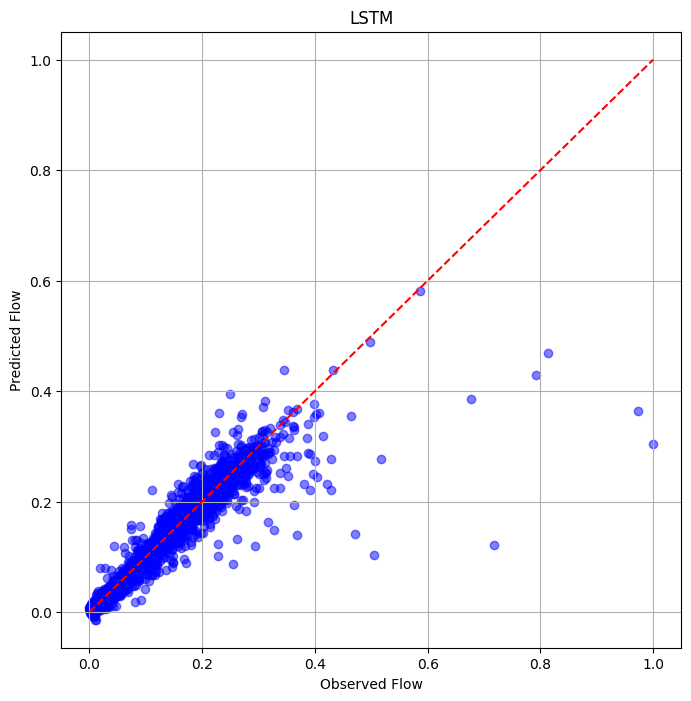

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('LSTM')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()

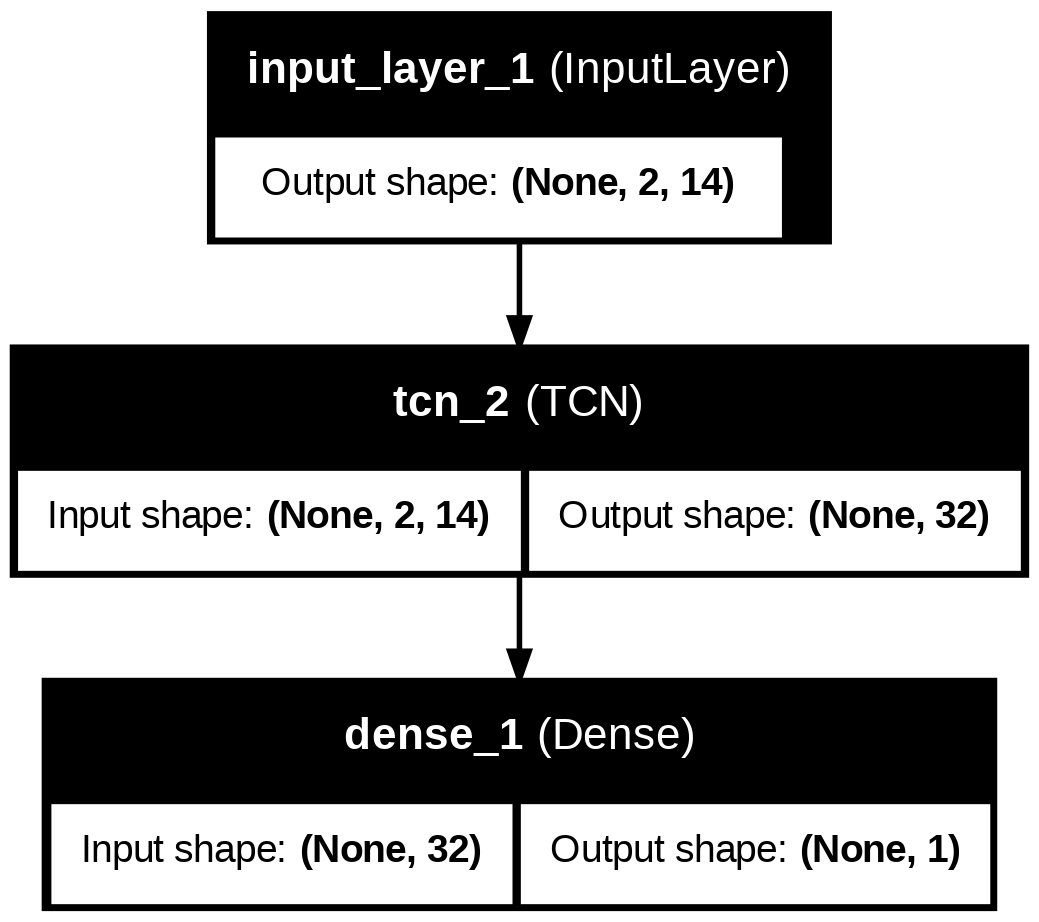

In [ ]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(best_model, to_file='tcn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Change the path to Kaggle's writable directory
best_model.save('/kaggle/working/best_model_tcn_4.h5')